In [1]:
# Import libraries
import pickle
import pennylane as qml
import torch
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
from utils import plot_confusion_matrix
import time
torch.manual_seed(0)
np.random.seed(0)

In [2]:
pip install utils

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda update -c conda-forge scikit-learn


Solving environment: ...working... 

Updating scikit-learn is constricted by 

anaconda -> requires scikit-learn==1.0.2=py39hf11a4ad_1

If you are sure you want an update of your package either try `conda update --all` or install a specific version of the package you want using `conda install <pkg>=<version>`

done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade utils

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Loading pickle object
with open('wind_turbine_19features-1.pickle', 'rb') as i:
    x = pickle.load(i)

In [6]:
# Training and Testing datasets as separate lists
xtrain = x['x_train']
ytrain = x['y_train']
xtest = x['x_test']
ytest = x['y_test']

# Size of training and testing data
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

#208 training data points, 104 testing data points and 19 features.

(208, 19)
(208, 2)
(104, 19)
(104, 2)


In [7]:
# Angle encoding
Amp_encoding = True
n = 4 # Number of features

# Extracting first n features
xtrain = xtrain[:, 0:n]
xtest = xtest[:, 0:n]

# Size of the features to use
print(xtrain.shape)
print(xtest.shape)

(208, 4)
(104, 4)


number of qubits: 4


(<Figure size 600x500 with 1 Axes>, <Axes:>)

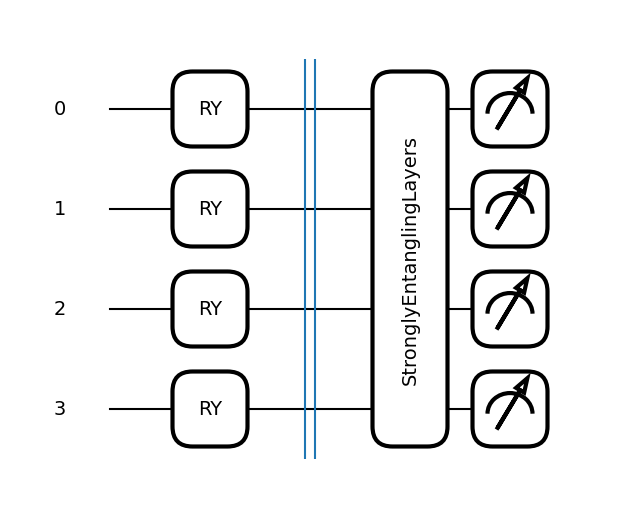

In [9]:
layers = 3
# Angle encoding
qubits = n #number of qubits is equal to number of features
device1 = qml.device("default.qubit", wires = qubits)
print(f"number of qubits: {qubits}")
@qml.qnode(device1, diff_method = "backprop")
def qnode(input1, w):
    # Encoding each feature into a qubit
    for i in range(qubits):
        qml.RY(1 * input1[i], i)
        qml.Barrier(i)     
    qml.StronglyEntanglingLayers( weights = w, wires = range(qubits))
    return [qml.expval(qml.PauliZ(wires = i)) for i in range(qubits)]
    
# Circuit Diagram
qml.draw_mpl(qnode)([1]*n, np.random.uniform(size=(layers, qubits, 3)))

Number of qubits used: 2


(<Figure size 600x300 with 1 Axes>, <Axes:>)

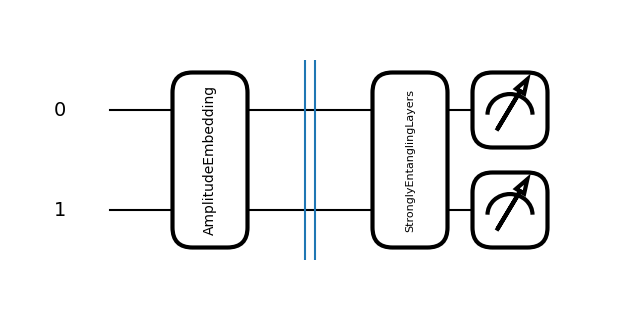

In [10]:
#Amplitude encoding
qubits = int(np.log2(n))


device1 = qml.device("default.qubit", wires = qubits)
print(f"Number of qubits used: {qubits}")
@qml.qnode(device1, diff_method = "backprop")
def qnode(inputs, weights):
    # Amplitude embedding Encodes 2^{n_features} into the amplitude vector of n qubits
    qml.AmplitudeEmbedding(features=inputs, wires=range(qubits), normalize=True)
    qml.Barrier(wires=range(qubits))
    qml.StronglyEntanglingLayers( weights = weights, wires = range(qubits))
    return [qml.expval(qml.PauliZ(wires = i)) for i in range(qubits)]
    
# Circuit Diagram
qml.draw_mpl(qnode)([1]*n, np.random.uniform(size=(layers, qubits, 3)))

In [11]:
# Quantum circuit into a torch layer

weights = {"weights": (layers, qubits, 3)}
q_layers = qml.qnn.TorchLayer(qnode, weights)
nl = [q_layers,
          torch.nn.Linear(qubits, 64),
          torch.nn.ReLU(),
          torch.nn.Linear(64, 64),
          torch.nn.ReLU(),
          torch.nn.Linear(64, 2)]

modelgen = torch.nn.Sequential(*nl)

In [12]:
# Testing the model
print(modelgen(torch.rand(1, n)))

tensor([[0.0145, 0.1024]], grad_fn=<AddmmBackward0>)


In [14]:
# Adam optimizer
optimizer = torch.optim.Adam(modelgen.parameters(), lr = 5e-3)
loss = torch.nn.CrossEntropyLoss()
batch_size = 20
batches = len(xtrain) // batch_size
epochs = 25
start_time = time.time()
xtrain = torch.tensor(xtrain, requires_grad = True).float()
ytrain = torch.tensor(ytrain, requires_grad = False).float()
dataloading = torch.utils.data.DataLoader(list(zip(xtrain, ytrain)), 
                                          batch_size = batch_size, 
                                          shuffle = True, drop_last = True)

for e in range(epochs):
    running_loss = 0

    for xs, ys in dataloading:
        optimizer.zero_grad()
        losse = loss(modelgen(xs).squeeze(), ys)
        losse.backward()
        optimizer.step()
        running_loss += losse

    averageloss = running_loss / batches
    print("Average loss over epoch {}: {:.5f}".format(e + 1, averageloss))
    
print(f"time spent: {round(time.time() - start_time, 1)} sec.")

Average loss over epoch 1: 0.67007
Average loss over epoch 2: 0.56405
Average loss over epoch 3: 0.49852
Average loss over epoch 4: 0.44776
Average loss over epoch 5: 0.44339
Average loss over epoch 6: 0.41839
Average loss over epoch 7: 0.41535
Average loss over epoch 8: 0.41676
Average loss over epoch 9: 0.44497
Average loss over epoch 10: 0.42687
Average loss over epoch 11: 0.43445
Average loss over epoch 12: 0.42677
Average loss over epoch 13: 0.43486
Average loss over epoch 14: 0.41448
Average loss over epoch 15: 0.40356
Average loss over epoch 16: 0.39466
Average loss over epoch 17: 0.39793
Average loss over epoch 18: 0.40255
Average loss over epoch 19: 0.40467
Average loss over epoch 20: 0.39977
Average loss over epoch 21: 0.39861
Average loss over epoch 22: 0.40530
Average loss over epoch 23: 0.40572
Average loss over epoch 24: 0.40877
Average loss over epoch 25: 0.40656
time spent: 45.2 sec.


In [17]:
ypred = modelgen(torch.tensor(xtest).float())
predictions = torch.argmax(ypred, axis = 1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, np.argmax(ytest, 1))]
a = sum(correct) / len(correct) #Accuracy

print(f"{a * 100}%")

78.84615384615384%


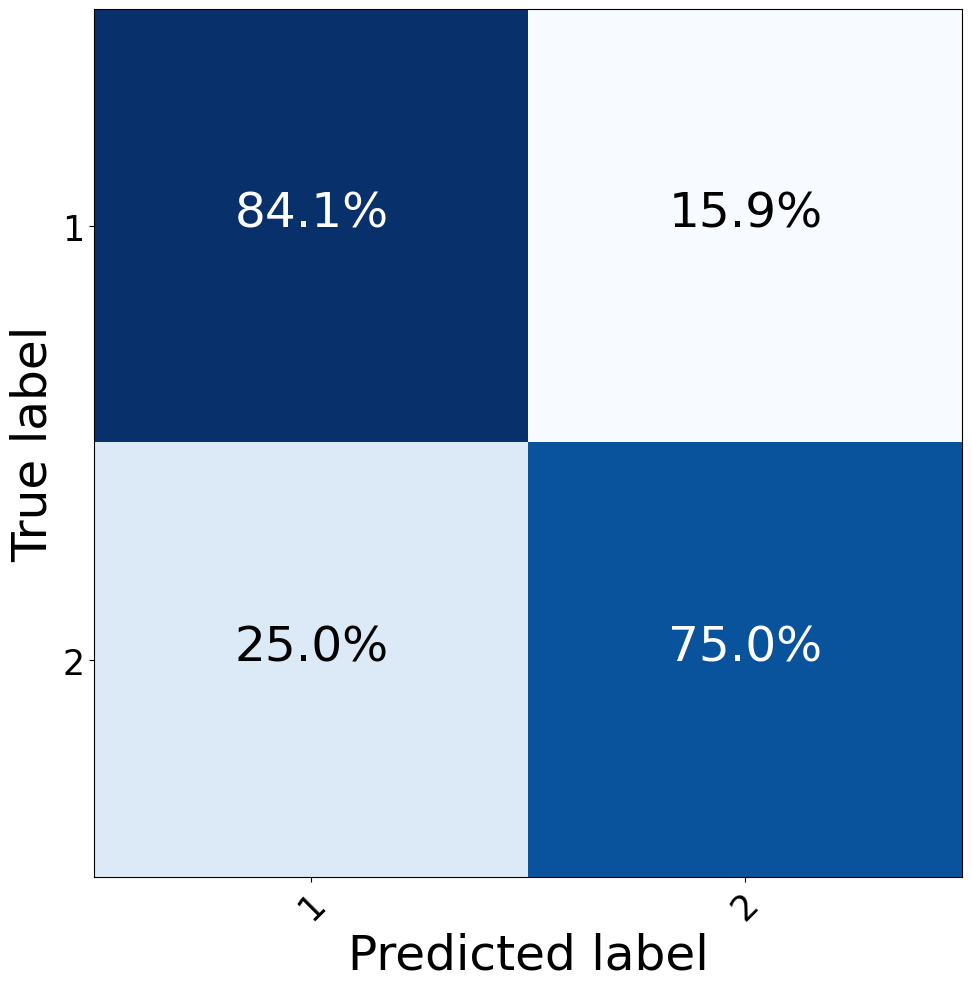

In [19]:
cmatrix = confusion_matrix(predictions,  np.argmax(ytest, 1))

plot_confusion_matrix(cmatrix, ["1", "2"], 2,
                      normalize = True, show = True)

In [20]:
df = pd.DataFrame([[4, '81.7%', '78.8%'],[8, 1, '79.8%'],[16, 1, '88.4%']],
                  columns=['Features', 'Encoding Accuracy(Angle)','Encoding Accuracy(Amplitude)'])
df.style

,Features,Encoding Accuracy(Angle),Encoding Accuracy(Amplitude)
0,4,81.7%,78.8%
1,8,1,79.8%
2,16,1,88.4%
